# Convolution Long short-term memory (Conv LSTM) for Predicting Fire Spread - Showcase and Tutorial

## 1. Introduction

The following notebook gives us some insight into the WildfireSpreadTS dataset and shows how we can use it to train a Conv-LSTM capable of predicting fire spread. 

After reading this notebook you will :
1. have a visual and technical understaring of the dataset,
2. know the problem definition, and
3. be able to load the dataset and train the model.


The dataset contains GeoTiff [1] files provided by Google Earth Engine and preprocessed in order to create HDF5 [2] files. The model can be trained on GeoTiff files as well but the preferred approach is HDF5 because it will provide a faster training time.


> [1] GeoTiff - public domain metadata standard that enables georeferencing information to be embedded within an image file.

> [2] HDF5 - able to store huge amounts of numerical data which can then be easily manipulated in python with numpy.

First we need to import all libraries and modules used

In [8]:
import os
import numpy as np
from matplotlib import pyplot as plt
import rasterio
import rasterio.plot
import imageio
from IPython.display import Image, display
import sys
from torch import optim

In [9]:
sys.path.append("../code")
from conv_lstm.train import EarlyStopper, Trainer
from conv_lstm.utils import create_config, get_loss_fn, get_scheduler, load_json_config, load_model

## 2. Data Visualization

A detected wildfire locations can last multiple days and has a timestamp of the last detection within a 24-hour period at 375m resolution.
A wildfire contains multiple timestamps, a single timestamp is represented in one tif file.


Lets now have a look at fire `fire_25547912` at timestamp `2021-09-12.tif`

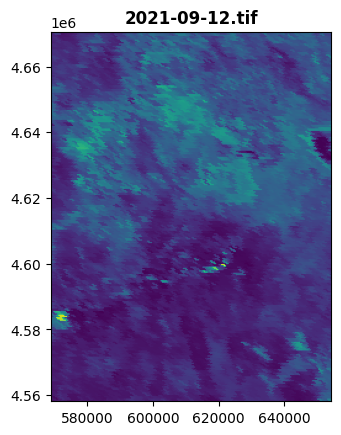

In [10]:
tif_file = "2021-09-12.tif"
image_path = "../data/sample_source_dataset/fire_25547912/" + tif_file

tiff = rasterio.open(image_path)
rasterio.plot.show(tiff, title = tif_file)
plt.show()

This is only the first channel - M11 which describes Shortwave Infrared. To plot every channel we need to define some functions and plot again.

In [11]:
def read_tiff_file(file_path):
  tiff = rasterio.open(file_path)
  img = tiff.read(tiff.indexes)
  labels = tiff.descriptions
  return tiff, img, labels

def plot_tiff(img, labels, title = ''):
  fig, axs = plt.subplots(4,6, figsize=(16,16))
  for idx, (ax, label) in enumerate(zip(axs.flatten(), labels)):
    im = np.expand_dims(img[idx],-1).astype(int)
    ax.imshow(im)
    ax.set_title(label)
  axs.flatten()[-1].remove()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

/var/folders/zb/tqxj94qx1b136lk4rjtpzlfr0000gn/T/ipykernel_2332/4227990575.py:10: RuntimeWarning: invalid value encountered in cast
  im = np.expand_dims(img[idx],-1).astype(int)


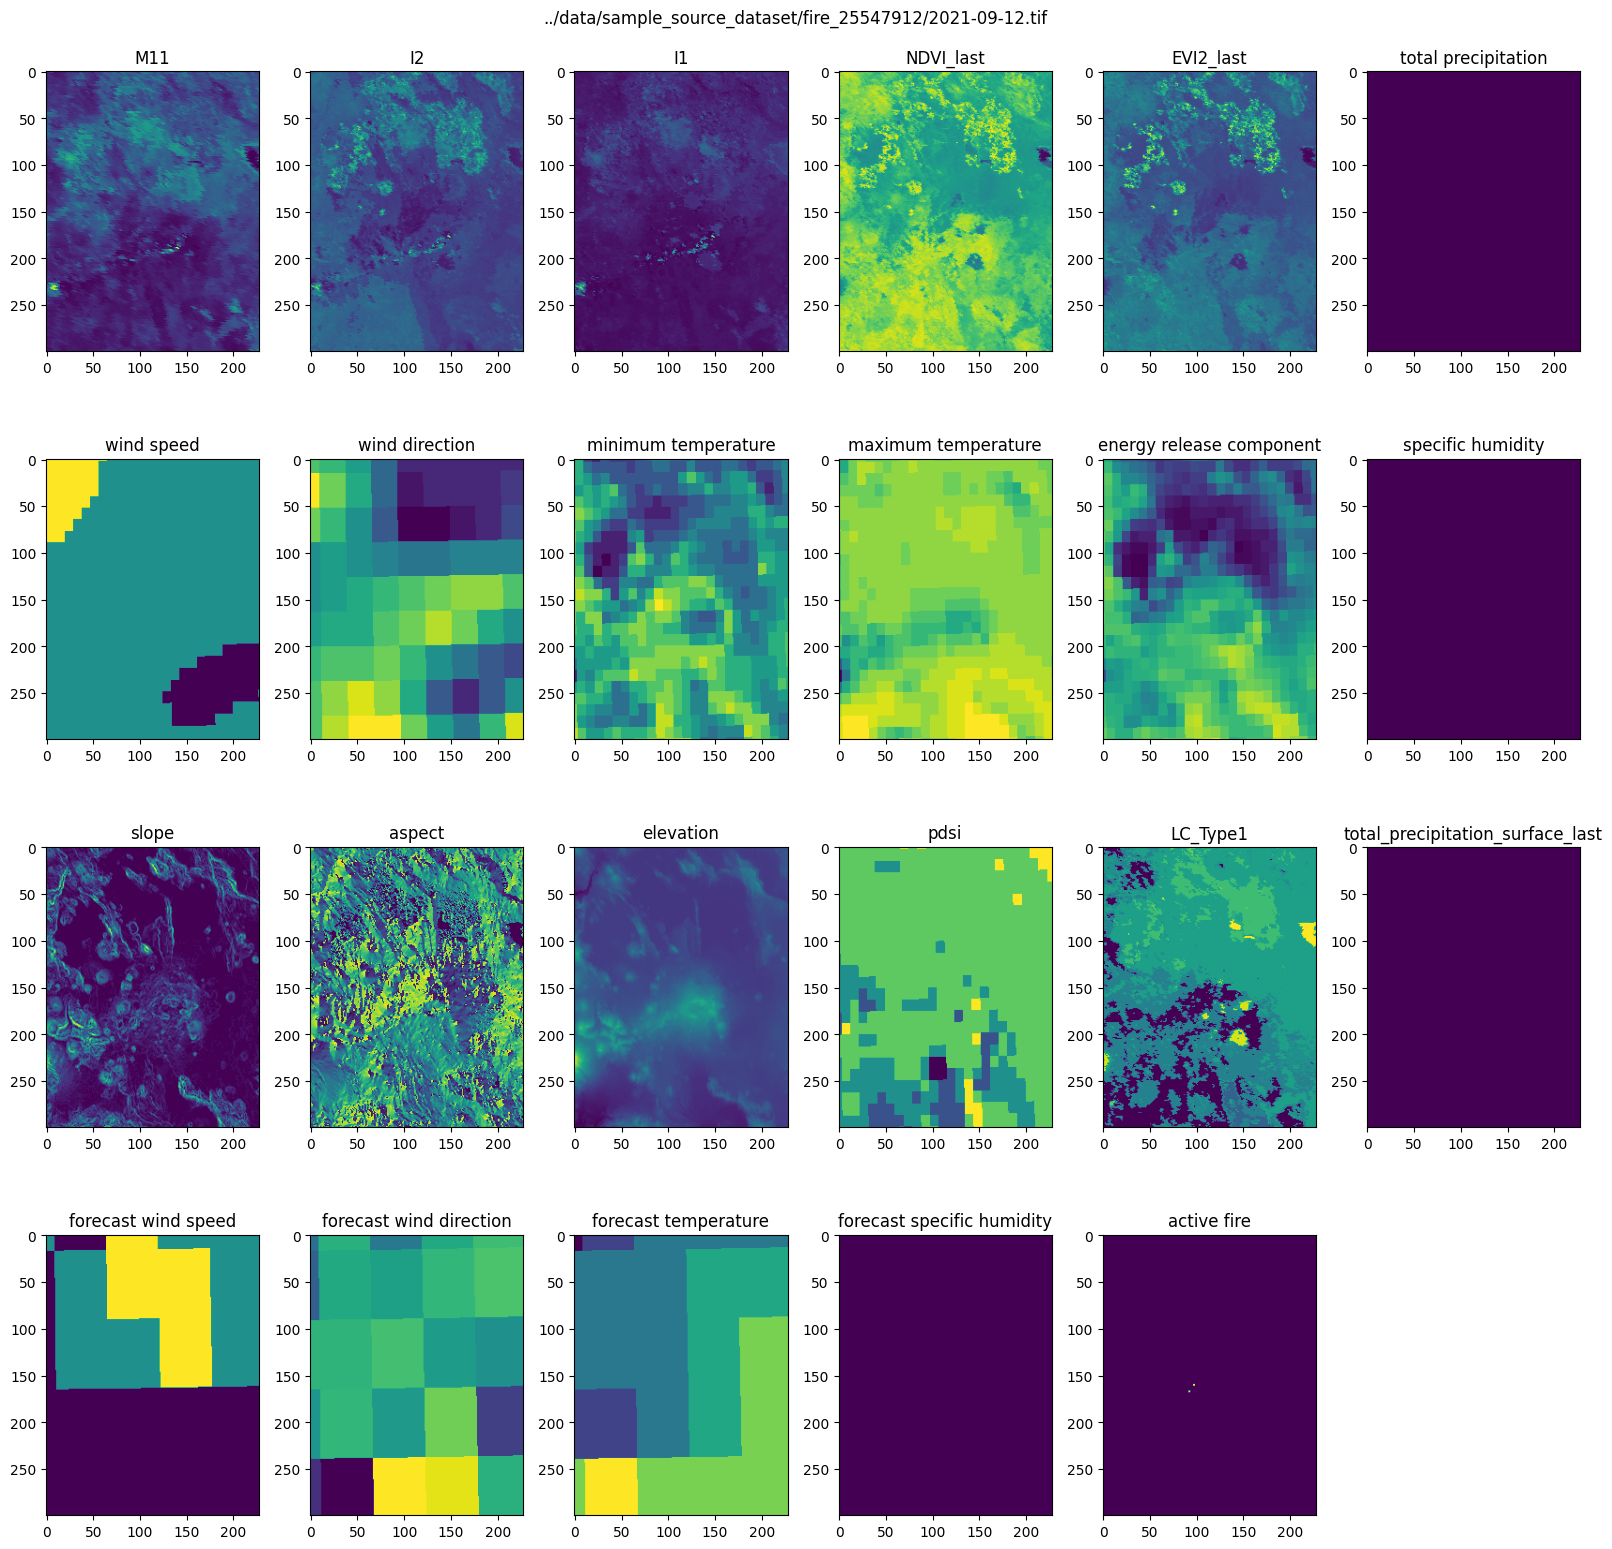

In [12]:
tiff, img, labels = read_tiff_file(image_path)
plot_tiff(img,labels, title = image_path)

Above are:
1. Vegetation & Fuel Conditions
* VIIRS Surface Reflectance - Band I1 (Red), Band I2 (Near-Infrared, NIR), and Band M11 (Shortwave Infrared, SWIR) are included because of their ability to distinguish healthy vegetation from burned areas and to detect clouds and smoke.
* NDVI (Normalized Difference Vegetation Index) – A vegetation health index, where higher values indicate greener, healthier vegetation.
* EVI2 (Enhanced Vegetation Index 2) – Similar to NDVI but more resistant to atmospheric interference like smoke and haze.
2. Weather Data
* Minimum and Maximum Surface Temperature – Impacting fuel moisture, fire ignition, and spread.
* Total Precipitation – Can suppress or slow wildfires.
* Wind Speed and Direction – Directly affects fire movement, spread, and intensity.
* Specific Humidity – Affecting fuel drying rates and fire intensity.
* Palmer Drought Severity Index (PDSI) – A measure of long-term drought conditions, indicating fire-prone areas.
3. Weather Forecast Data
* Forecasted Average Temperature – Predicted temperature for the next 24 hours, crucial for estimating fire behavior.
* Forecasted Wind Speed & Direction – Predicted wind conditions, helping anticipate fire spread direction.
4. Topography & Land Cover 
* Land Cover Type (IGBP classification) and Elevation – To understand the fuel type and topography of the surface.
* Slope – Measures the steepness of the terrain which affects fire spread.
* Aspect (Terrain Orientation) – The direction a slope faces, affecting sunlight exposure and fuel drying rates.


We can see some data points in the active fire channel but not much. This is because the fire just started at this timestamp.


Time to iterate through all of the timestamps and create some flashy gifs 🔥.

In [13]:
def create_band_gif(folder_path, band_idx, label, output_gif='output.gif', duration=0.5, background_value = 15):
    """
    Creates and displays a GIF from all TIFF files in a folder for a specific band.
    
    Args:
        folder_path (str): Path to the folder containing TIFF files.
        band_idx (int): Index of the band to use.
        label (str): Label for the GIF frames.
        output_gif (str): Output path for the GIF.
        duration (float): Time between frames in seconds.
    """
    images = []
    tiff_files = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]

    for file in sorted(tiff_files):
        file_path = os.path.join(folder_path, file)
        _, img, _ = read_tiff_file(file_path)
        
        if band_idx >= img.shape[0]:
            print(f"Band index {band_idx} out of range for file {file}")
            continue
        
        band_img = img[band_idx]
        band_img[np.isnan(band_img)] = background_value
        # print(band_img.min(), band_img.max())
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(band_img, cmap='inferno')
        ax.set_title(f"{label} - {file}")
        ax.axis('off')
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        plt.close(fig)
    
    if images:
        imageio.mimsave(output_gif, images, duration=duration, loop=0)
        print(f"GIF saved to {output_gif}")
        
        display(Image(filename=output_gif))
    else:
        print("No images were processed to create the GIF.")


/var/folders/zb/tqxj94qx1b136lk4rjtpzlfr0000gn/T/ipykernel_2332/2397256123.py:32: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


GIF saved to ../data/sample_source_dataset/fire_25547912/gifs/active_fire.gif


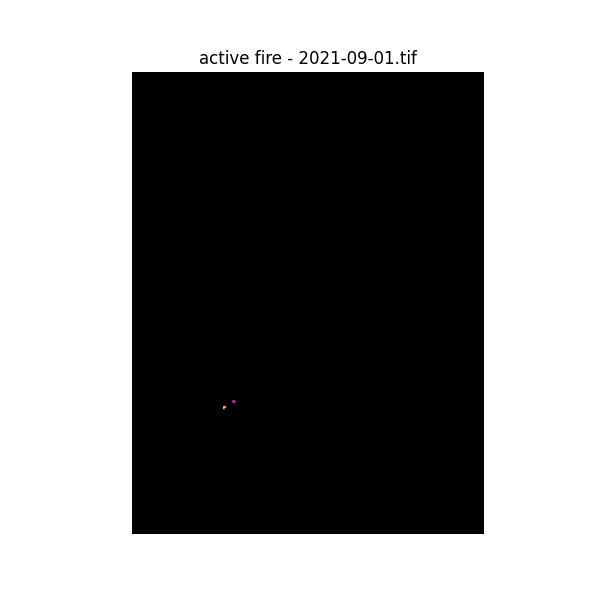

In [14]:
fire_path = '../data/sample_source_dataset/fire_25547912'
fire_gif_path = fire_path + "/gifs/"
output_gif = fire_gif_path + "active_fire.gif"

os.makedirs(fire_gif_path, exist_ok=True)
create_band_gif(fire_path, 22, labels[22], output_gif = output_gif)

## 3. Training the Conv-LSTM model

The default configuration for the model can be seen and edited in "../code/conv_lstm/config.json". 

1. Dataset Parameters

* data_dir: "./dataset_hdf5" 

* train_years: [2018, 2019] 

* val_years: [2019] 


2. Input/Output Data Settings

* time_steps: 5 

* img_size: [128, 128] 

* input_channels: 1 

* output_channels: 1 

* features_to_keep: [-1] 


3. Model Training Settings

* epochs: 50

* batch_size: 64

* learning_rate: 0.01

* num_workers: 3


4. Model Architecture Settings

* kernel_size: [3, 3]

* num_layers: 1

5. Optimization and Scheduler

* loss_fn: "l1"

* scheduler: "cosine"

* lr_T_max: 30


In [11]:
args = load_json_config("../code/conv_lstm/config.json")
CONFIG = create_config(args)
num_workers = CONFIG["num_workers"] or os.cpu_count() - 1

We have defined an early stop function which monitors the validation loss and stops the model if no improvement can be seen. 

The optimizer used is Adam which automatically adjusts the learning rate for each parameter based on the first moment (mean) and second moment (variance) of the gradients.

In [12]:
early_stopper = EarlyStopper(patience=10, min_delta=0)
model = load_model(CONFIG)
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])

In [13]:
criterion = get_loss_fn(kind=CONFIG["loss_fn"])
scheduler = get_scheduler(optimizer, kind=CONFIG["scheduler"])

In [14]:
trainer = Trainer(
    early_stopper=early_stopper,
    model=model,
    criterion=criterion,
    scheduler=scheduler,
    optimizer=optimizer,
    device=CONFIG["device"],
    epochs=CONFIG["epochs"],
    train_years=CONFIG["train_years"],
    val_years=CONFIG["val_years"],
    num_workers=num_workers,
    data_dir=CONFIG["data_dir"],
    time_steps=CONFIG["time_steps"],
    crop_side_length=CONFIG["img_size"][0],
    stats_years=CONFIG["train_years"],
    features_to_keep=CONFIG["features_to_keep"],
)


In [15]:
train_loader = trainer.get_dataloader(
    batch_size=CONFIG["batch_size"],
    is_train=True,
    subset_size=200,
)

val_loader = trainer.get_dataloader(
    is_train=False, subset_size=20, batch_size=1, shuffle=False
)

In [ ]:
trainer.train_loop(CONFIG, train_loader, criterion)

After training, this model will be saved in "code/conv_lstm/runs". We can load the model into memory and run inference on it.

In [38]:
from conv_lstm.visualization.plot_predictions import run_inference, load_dataset
import torch
from torch.utils.data import DataLoader


map_location=torch.device('cpu')
args = {
    "data_dir" : None,
    "model_path" : "../code/conv_lstm/runs/run_13/1.pth",
    "config" : "../code/conv_lstm/config.json",
    "save_to" : "../results/predictions",
    "batch_size" : 1,
    "time_steps" : 5 ,
    "threshold" : 9e-5,
    "val_year" : 2020,
    "device" : "cpu",
}

In [39]:
json_config = load_json_config(args["config"])
config = create_config(json_config)

In [40]:
if args["device"] is not None:
    device = torch.device(args["device"])
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
model = load_model(config)
model.load_state_dict(torch.load(args["model_path"], map_location=device))
model=model.to(device)

/var/folders/zb/tqxj94qx1b136lk4rjtpzlfr0000gn/T/ipykernel_2332/4049875038.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args["model_p

In [42]:
dataset = load_dataset(config["data_dir"], config["val_years"][0], config["time_steps"], config["img_size"],
                        config["features_to_keep"])
dataloader = DataLoader(dataset, batch_size=args["batch_size"], shuffle=False)

In [43]:
run_inference(model, dataloader, device, args["save_to"], args["threshold"])

For predictions and using them with QUBO please look at the qubo.ipynb notebook